In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [7]:
# Reading various csv into dataframe
sales_train = pd.read_csv("sales_train_validation.csv")
date = pd.read_csv("calendar.csv")
# filter to get single item
single = sales_train[sales_train["id"]=="FOODS_3_090_CA_3_validation"].iloc[:,6:].T.reset_index().copy()
datetime = date[["date","d"]].copy()
single = pd.merge(left=single,right=datetime,left_on="index",right_on="d",how="left")
#  Data processing to prepare for modeling
single.drop(["d","index"],axis=1,inplace=True)
single["date"] = pd.to_datetime(single["date"])
single = single.rename({"date":"ds",single.columns[0]:"y"},axis=1)[["ds","y"]]
ts= single.iloc[-98:,:].copy()

KeyError: "['ds'] not in index"

In [78]:
single = sales_train[sales_train["id"]=="FOODS_3_090_CA_3_validation"].iloc[:,6:].T.reset_index().copy()
single

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
8412,FOODS_3_090_CA_3_validation,FOODS_3_090,FOODS_3,FOODS,CA_3,CA,108,132,102,120,...,129,160,204,86,100,88,77,141,139,130


In [94]:
single = sales_train[sales_train["id"]=="FOODS_3_090_CA_3_validation"].iloc[:,6:].T.reset_index().copy()
single = pd.merge(left=single,right=datetime,left_on="index",right_on="d",how="left")
single.drop(["d","index"],axis=1,inplace=True)
single["date"] = pd.to_datetime(single["date"])
single = single.rename({"date":"ds",single.columns[0]:"y"},axis=1)
# [["ds","y"]]
# ts= single.iloc[-98:,:].copy()
single.dtypes

y              int64
ds    datetime64[ns]
dtype: object

In [89]:
ts

,ds,y
1815,2016-01-18,53
1816,2016-01-19,73
1817,2016-01-20,55
1818,2016-01-21,68
1819,2016-01-22,94
...,...,...
1908,2016-04-20,88
1909,2016-04-21,77
1910,2016-04-22,141
1911,2016-04-23,139


In [95]:
# use past 3 months (84 days) data to forecast the next 2 weeks
duration = 14
train = ts.iloc[:-duration,:].copy()
test = ts.iloc[-duration:,:].copy()
test

,ds,y
1899,2016-04-11,107
1900,2016-04-12,84
1901,2016-04-13,88
1902,2016-04-14,90
1903,2016-04-15,129
1904,2016-04-16,160
1905,2016-04-17,204
1906,2016-04-18,86
1907,2016-04-19,100
1908,2016-04-20,88


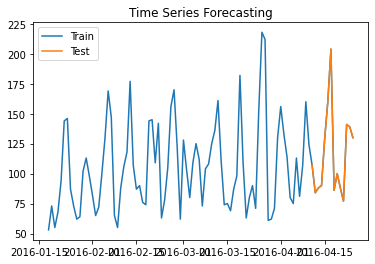

In [41]:
# Visualization
# plt.figure(figsize=(12,12))
plt.plot(train["ds"],train["y"],label="Train")
plt.plot(test["ds"],test["y"],label="Test")
plt.title("Time Series Forecasting")
plt.legend()

In [40]:
## Persistence algorithm
pred= []
for i in range(duration):
    pred.append(train.iloc[-1,1])
    # add test data to train
    train = train.append(test.iloc[i])

In [44]:
pred

[124, 107, 84, 88, 90, 129, 160, 204, 86, 100, 88, 77, 141, 139]

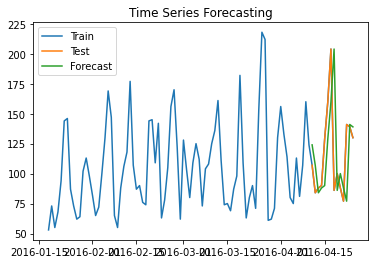

In [48]:
# Visualization
# plt.figure(figsize=(12,12))
plt.plot(train["ds"],train["y"],label="Train")
plt.plot(test["ds"],test["y"],label="Test")
plt.plot(test["ds"],pred,label="Forecast")
plt.title("Time Series Forecasting")
plt.legend()

In [49]:
from sklearn.metrics import mean_squared_error
rmse =  np.sqrt(mean_squared_error(pred,test["y"]))
print("RMSE:",rmse)

RMSE: 41.250108224966255


In [50]:
# Split into train and test set
duration = 14
train = ts.iloc[:-duration,:].copy().set_index("ds")
test = ts.iloc[-duration:,:].copy().set_index("ds")

In [53]:
import pmdarima as pm
model = pm.auto_arima(train,start_p=0,start_q=0,test="adf",max_p=3,max_q=3,error_action="ignore",
                      suppress_warnings=True,seasonal=False)
# prediction
pred = model.predict(duration)
pred

array([ 87.52631742,  69.4938382 ,  76.8433471 , 106.11500068,
       134.99549972, 141.74846009, 121.57033198,  89.99218409,
        70.93045802,  78.57644547, 106.83614242, 134.17461678,
       140.02303557, 120.25072132])

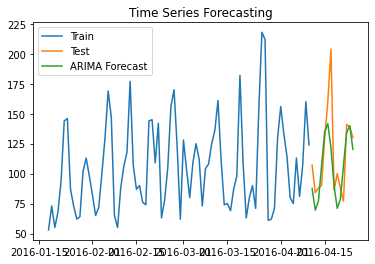

In [61]:
# Visualization
# plt.figure(figsize=(12,12))
plt.plot(train.index,train["y"],label="Train")
plt.plot(test.index,test["y"],label="Test")
plt.plot(test.index,pred,label="ARIMA Forecast")
plt.title("Time Series Forecasting")
plt.legend()

In [67]:
train

,y
ds,
2016-01-18,53
2016-01-19,73
2016-01-20,55
2016-01-21,68
2016-01-22,94
...,...
2016-04-06,113
2016-04-07,81
2016-04-08,107


In [70]:
from fbprophet import Prophet
model = Prophet()
model.fit(train)

# Making prediction
future = model.make_future_dataframe(duration,include_history=False)
pred = model.predict(future)
pred = pred[["yhat","yhat_lower","yhat_upper"]]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


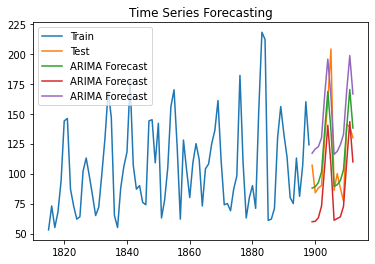

In [72]:
# Visualization
# plt.figure(figsize=(12,12))
plt.plot(train.index,train["y"],label="Train")
plt.plot(test.index,test["y"],label="Test")
plt.plot(test.index,pred,label="ARIMA Forecast")
plt.title("Time Series Forecasting")
plt.legend()